# Notebook 4 - Property modeling with conventional molecular descriptors

By Vincent Blay, July 2021

This notebooks illustrates the use of conventional molecular descriptors from rdkit to model the properties in this work.

In [13]:
pwd

'C:\\Users\\Enka\\Desktop\\LDRD\\macaw_repo\\notebooks'

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import Descriptors, MolFromSmiles
from rdkit.ML.Descriptors import MoleculeDescriptors

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector

%run "./plotting.py"

In [15]:
def smiles_to_descriptors(smiles):
    smiles = list(smiles)
    names = [x[0] for x in Descriptors._descList]
    calc = MoleculeDescriptors.MolecularDescriptorCalculator(names)

    idx = []
    D = []
    for i in range(len(smiles)):
        smi = smiles[i]
        mol = MolFromSmiles(smi)
        if mol is not None:
            descriptors = calc.CalcDescriptors(mol)
            D.append(descriptors)
            idx.append(i)

    D = pd.to_numeric(D, errors='coerce') # converts any string to nan

    # Let us now remove columns with any nan value
    D = pd.DataFrame(D)
    D.columns = names
    D[abs(D) > 1e5] = np.nan
    D.dropna(axis=1, how='any', inplace=True)
    
    # Let us also remove columns with very small standard deviation
    sd = D.std(axis=1)
    D.drop(np.where(sd<0.005)[0],axis=1)
    
    return D, idx

## Research Octane Number (RON)

Let us load the data and look at the distribution:

In [16]:
df = pd.read_csv("../data/data_RON.csv")
smiles = df.Smiles
Y = df.RON
print(len(smiles))

194


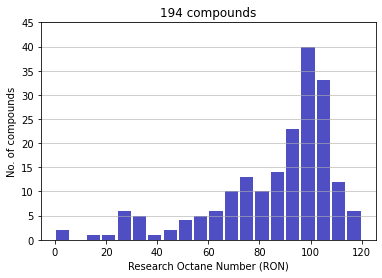

In [17]:
plot_histogram(Y, xlabel="Research Octane Number (RON)")

Let us now compute the molecular descriptors:

In [18]:
D, idx = smiles_to_descriptors(smiles)

Y = Y[idx]

In [19]:
D.head()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,2.1875,0.369792,2.1875,0.369792,0.408425,98.189,84.077,98.1096,42,0,...,0,0,0,0,0,0,0,0,0,0
1,2.25347,0.852963,2.25347,0.852963,0.492217,112.216,96.088,112.125,48,0,...,0,0,0,0,0,0,0,0,0,0
2,10.2431,0.453704,10.2431,0.453704,0.42968,84.118,76.054,84.0575,34,0,...,0,0,0,0,0,0,0,0,0,0
3,1.5,1.5,1.5,1.5,0.408362,70.135,60.055,70.0783,30,0,...,0,0,0,0,0,0,0,0,0,0
4,1.5,1.5,1.5,1.5,0.422316,84.162,72.066,84.0939,36,0,...,0,0,0,0,0,0,0,0,0,0


Let us split the data in training and validation sets:

In [20]:
D_train, D_test, y_train, y_test = train_test_split(D, Y, test_size = 0.2, random_state = 42)

Now we want to select those descriptors that we will use to train the model.

In [21]:
%%time

regr = LinearRegression()

sfs = SequentialFeatureSelector(regr, n_features_to_select=15)
sfs.fit(D_train, y_train)
print("Features selected by forward sequential selection: "
      f"{D.columns[sfs.get_support()].tolist()}")

Features selected by forward sequential selection: ['MaxEStateIndex', 'MinEStateIndex', 'BalabanJ', 'Chi3n', 'PEOE_VSA10', 'PEOE_VSA6', 'SMR_VSA5', 'SlogP_VSA4', 'EState_VSA5', 'EState_VSA6', 'EState_VSA8', 'VSA_EState5', 'FractionCSP3', 'NumRotatableBonds', 'fr_unbrch_alkane']
Wall time: 31.5 s


In [22]:
D_train.shape

(155, 208)

Now we use the selected descriptors to train a Support Vector Regressor (SVR) from the `sklearn` package.

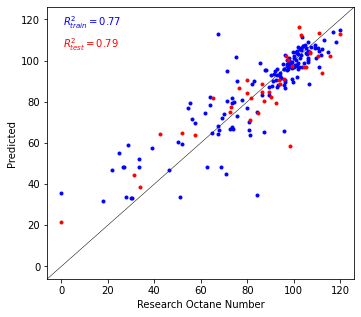

In [23]:
X_train = sfs.transform(D_train)
X_test = sfs.transform(D_test)

regr = SVR(kernel='rbf', C=100, epsilon=3)
regr.fit(X_train,y_train)

# Train set predictions
y_train_pred = regr.predict(X_train)

# Test set predictions
y_test_pred = regr.predict(X_test)

# Parity plot
parity_plot(x=y_train, y=y_train_pred, x_test=y_test, y_test=y_test_pred,
            xlabel="Research Octane Number", savetitle="../results/rdkit_RON_ls.png") 

## Cetane Number (CN)

In [30]:
df = pd.read_csv("../data/data_CN.csv")
smiles = df.Smiles
Y = df.CN
print(len(smiles))

545


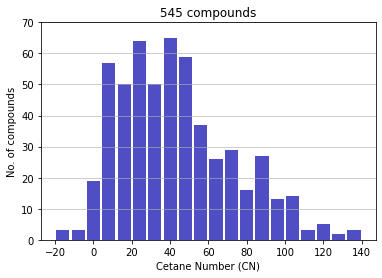

In [31]:
plot_histogram(Y, xlabel="Cetane Number (CN)")

In [32]:
D, idx = smiles_to_descriptors(smiles)

Y = Y[idx]

In [33]:
D_train, D_test, y_train, y_test = train_test_split(D, Y, test_size=0.2, random_state=42)

In [34]:
%%time

regr = LinearRegression()

sfs = SequentialFeatureSelector(regr, n_features_to_select=15)
sfs.fit(D_train, y_train)
print("Features selected by forward sequential selection: "
      f"{D.columns[sfs.get_support()].tolist()}")

Features selected by forward sequential selection: ['FpDensityMorgan1', 'FpDensityMorgan2', 'BCUT2D_MRLOW', 'BertzCT', 'PEOE_VSA10', 'PEOE_VSA11', 'SMR_VSA1', 'SMR_VSA10', 'TPSA', 'VSA_EState1', 'VSA_EState5', 'FractionCSP3', 'NumAliphaticHeterocycles', 'fr_Ar_OH', 'fr_unbrch_alkane']
Wall time: 42 s


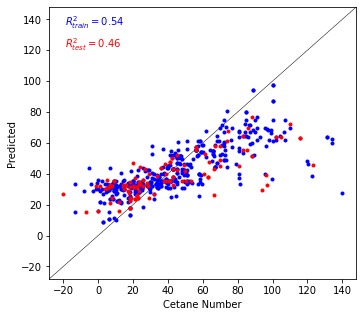

In [35]:
X_train = sfs.transform(D_train)
X_test = sfs.transform(D_test)

regr = SVR(kernel='rbf', C=100, epsilon=5)
regr.fit(X_train,y_train)

# Train set predictions
y_train_pred = regr.predict(X_train)

# Test set predictions
y_test_pred = regr.predict(X_test)

# Parity plot
parity_plot(x=y_train, y=y_train_pred, x_test=y_test, y_test=y_test_pred, 
            xlabel="Cetane Number", savetitle="../results/rdkit_CN_ls.png") 

## Yield Sooting Index

In [36]:
df = pd.read_csv("../data/data_YSI.csv")
smiles = df.Smiles
Y = df.YSI
print(len(smiles))

610


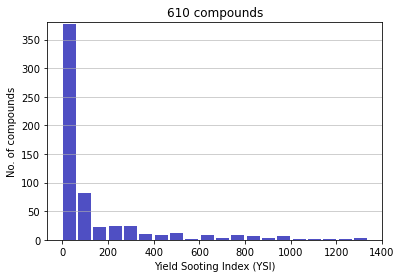

In [37]:
plot_histogram(Y, xlabel="Yield Sooting Index (YSI)")

In [38]:
D, idx = smiles_to_descriptors(smiles)

Y = Y[idx]

In [39]:
D_train, D_test, y_train, y_test = train_test_split(D, Y, test_size = 0.2, random_state = 42)

In [40]:
%%time

regr = LinearRegression()

sfs = SequentialFeatureSelector(regr, n_features_to_select=15)
sfs.fit(D_train, y_train)
print("Features selected by forward sequential selection: "
      f"{D.columns[sfs.get_support()].tolist()}")

Features selected by forward sequential selection: ['BertzCT', 'Chi3n', 'PEOE_VSA7', 'SMR_VSA2', 'SMR_VSA9', 'SlogP_VSA8', 'EState_VSA7', 'VSA_EState4', 'FractionCSP3', 'NumAliphaticCarbocycles', 'NumAromaticCarbocycles', 'NumHeteroatoms', 'fr_Ar_OH', 'fr_NH2', 'fr_para_hydroxylation']
Wall time: 58.1 s


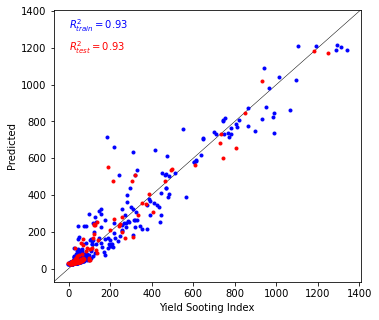

In [41]:
X_train = sfs.transform(D_train)
X_test = sfs.transform(D_test)

regr = SVR(kernel='rbf', C=500, epsilon=20)
regr.fit(X_train,y_train)

# Train set predictions
y_train_pred = regr.predict(X_train)

# Test set predictions
y_test_pred = regr.predict(X_test)

# Parity plot
parity_plot(x=y_train, y=y_train_pred, x_test=y_test, y_test=y_test_pred,
            xlabel="Yield Sooting Index", savetitle="../results/rdkit_YSI_ls.png") 

##  Melting Point (MP)

In [42]:
df = pd.read_csv("../data/data_MP.csv")
smiles = df.Smiles
Y = df.mpC
print(len(smiles))

27976


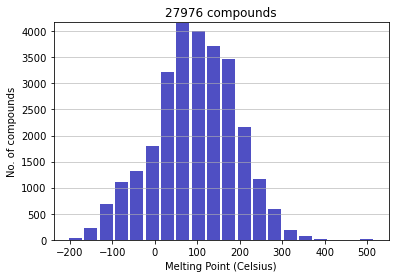

In [43]:
plot_histogram(Y, xlabel="Melting Point (Celsius)")

In [44]:
%%capture

D, idx = smiles_to_descriptors(list(smiles))

Y = Y[idx]

In [45]:
D_train, D_test, y_train, y_test = train_test_split(D, Y, test_size = 0.2, random_state = 42)

This dataset is too big to use the SequentialFeatureSelector directly. Let us downsample it for the feature selection step:

In [46]:
idx = np.random.choice(range(len(D_train)), size=3000, replace=False)

D_train_downsampled = D_train.iloc[idx]
y_train_downsampled = y_train.iloc[idx]

In [47]:
%%time

regr = LinearRegression()

sfs = SequentialFeatureSelector(regr, n_features_to_select=15, cv=5, n_jobs=5)
sfs.fit(D_train_downsampled, y_train_downsampled)
print("Features selected by forward sequential selection: "
      f"{D.columns[sfs.get_support()].tolist()}")

Features selected by forward sequential selection: ['MaxAbsEStateIndex', 'MinAbsEStateIndex', 'qed', 'FpDensityMorgan2', 'BertzCT', 'SMR_VSA10', 'SlogP_VSA8', 'TPSA', 'EState_VSA1', 'EState_VSA5', 'FractionCSP3', 'NHOHCount', 'NumAliphaticRings', 'NumAromaticHeterocycles', 'fr_COO']
Wall time: 1min 2s


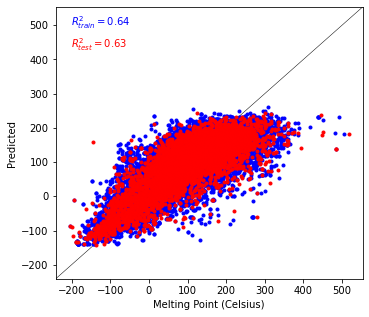

In [49]:
X_train = sfs.transform(D_train)
X_test = sfs.transform(D_test)

regr = SVR(kernel = "rbf", C=100, epsilon = 20)
regr.fit(X_train,y_train)

# Train set predictions
y_train_pred = regr.predict(X_train)

# Test set predictions
y_test_pred = regr.predict(X_test)

# Parity plot
parity_plot(x=y_train, y=y_train_pred, x_test=y_test, y_test=y_test_pred,
            xlabel="Melting Point (Celsius)", savetitle="../results/rdkit_MP_ls.png") 

## Flash Point (FP)

In [58]:
df = pd.read_csv("../data/data_FP.csv")
smiles = df.Smiles
Y = df.FP
print(len(smiles))

631


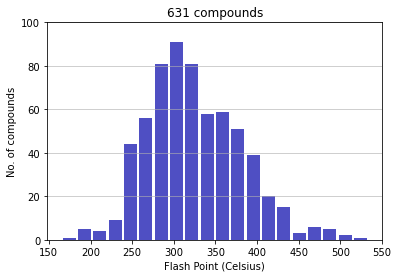

In [59]:
plot_histogram(Y, xlabel="Flash Point (Celsius)")

In [60]:
D, idx = smiles_to_descriptors(smiles)

Y = Y[idx]

In [61]:
D_train, D_test, y_train, y_test = train_test_split(D, Y, test_size = 0.2, random_state = 42)

In [62]:
%%time

regr = LinearRegression()

sfs = SequentialFeatureSelector(regr, n_features_to_select=15)
sfs.fit(D_train, y_train)
print("Features selected by forward sequential selection: "
      f"{D.columns[sfs.get_support()].tolist()}")

Features selected by forward sequential selection: ['HeavyAtomMolWt', 'FpDensityMorgan1', 'FpDensityMorgan3', 'BCUT2D_CHGLO', 'Chi0', 'SMR_VSA6', 'EState_VSA8', 'VSA_EState3', 'VSA_EState4', 'FractionCSP3', 'NHOHCount', 'NumAliphaticHeterocycles', 'NumSaturatedCarbocycles', 'fr_allylic_oxid', 'fr_aryl_methyl']
Wall time: 44.8 s


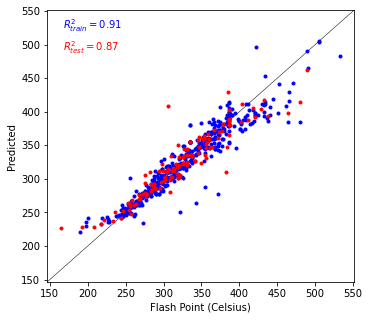

In [63]:
X_train = sfs.transform(D_train)
X_test = sfs.transform(D_test)

regr = SVR(kernel='rbf', C=300, epsilon=2)
regr.fit(X_train,y_train)

# Train set predictions
y_train_pred = regr.predict(X_train)

# Test set predictions
y_test_pred = regr.predict(X_test)

# Parity plot
parity_plot(x=y_train, y=y_train_pred, x_test=y_test, y_test=y_test_pred,
            xlabel="Flash Point (Celsius)", savetitle="../results/rdkit_FP_ls.png") 

## Histamine receptor pKi

In [64]:
df = pd.read_csv("../data/data_H1.csv")
Y = df.pKi
smiles = df.Smiles
print(len(smiles))

1214


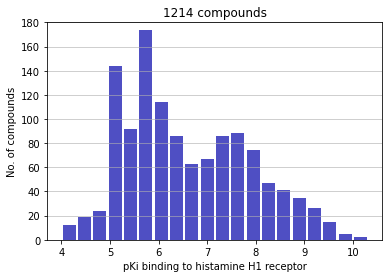

In [65]:
plot_histogram(Y, xlabel="pKi binding to histamine H1 receptor")

In [66]:
D, idx = smiles_to_descriptors(smiles)

Y = Y[idx]

In [67]:
D_train, D_test, y_train, y_test = train_test_split(D, Y, test_size = 0.2, random_state = 42)

In [68]:
%%time

regr = LinearRegression()

sfs = SequentialFeatureSelector(regr, n_features_to_select=15)
sfs.fit(D_train, y_train)
print("Features selected by forward sequential selection: "
      f"{D.columns[sfs.get_support()].tolist()}")

Features selected by forward sequential selection: ['MinAbsEStateIndex', 'BalabanJ', 'HallKierAlpha', 'PEOE_VSA9', 'SMR_VSA7', 'SMR_VSA9', 'EState_VSA7', 'VSA_EState9', 'NHOHCount', 'NOCount', 'fr_Ndealkylation1', 'fr_ketone_Topliss', 'fr_methoxy', 'fr_para_hydroxylation', 'fr_piperdine']
Wall time: 49.8 s


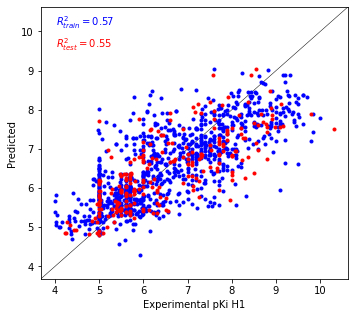

In [69]:
X_train = sfs.transform(D_train)
X_test = sfs.transform(D_test)

regr = SVR(kernel = "rbf", C=10, epsilon = .3)
regr.fit(X_train,y_train)

# Train set predictions
y_train_pred = regr.predict(X_train)


# Test set predictions
y_test_pred = regr.predict(X_test)

# Parity plot
parity_plot(x=y_train, y=y_train_pred, x_test=y_test, y_test=y_test_pred,
            xlabel='Experimental pKi H1', savetitle="../results/rdkit_H1_ls.png") 

## Muscarinic receptor pKi

In [70]:
df = pd.read_csv("../data/data_M2.csv")
Y = df.pKi
smiles = df.Smiles
print(len(smiles))

1145


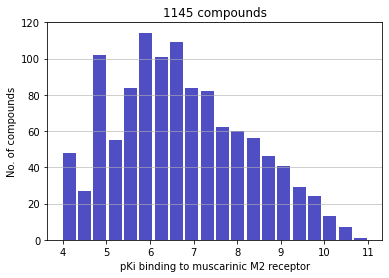

In [71]:
plot_histogram(Y, xlabel="pKi binding to muscarinic M2 receptor")

In [72]:
D, idx = smiles_to_descriptors(smiles)

Y = Y[idx]

In [73]:
D_train, D_test, y_train, y_test = train_test_split(D, Y, test_size = 0.2, random_state = 42)

In [74]:
%%time

regr = LinearRegression()

sfs = SequentialFeatureSelector(regr, n_features_to_select=15)
sfs.fit(D_train, y_train)
print("Features selected by forward sequential selection: "
      f"{D.columns[sfs.get_support()].tolist()}")

Features selected by forward sequential selection: ['FpDensityMorgan1', 'FpDensityMorgan2', 'Chi3v', 'PEOE_VSA5', 'SlogP_VSA3', 'SlogP_VSA5', 'SlogP_VSA8', 'EState_VSA3', 'VSA_EState2', 'FractionCSP3', 'MolLogP', 'fr_aryl_methyl', 'fr_halogen', 'fr_sulfonamd', 'fr_sulfone']
Wall time: 41.4 s


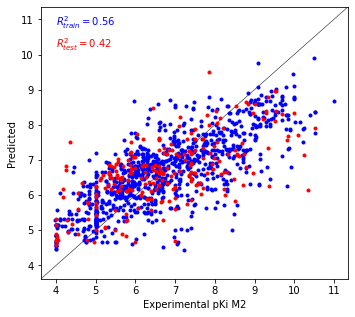

In [75]:
X_train = sfs.transform(D_train)
X_test = sfs.transform(D_test)

regr = SVR(kernel='rbf', C=3, epsilon=.5)
regr.fit(X_train,y_train)

# Train set predictions
y_train_pred = regr.predict(X_train)

# Test set predictions
y_test_pred = regr.predict(X_test)

# Parity plot
parity_plot(x=y_train, y=y_train_pred, x_test=y_test, y_test=y_test_pred,
            xlabel="Experimental pKi M2", savetitle="../results/rdkit_M2_ls.png")